In [1]:
import re 

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.gridspec import GridSpec

from shapely import geometry
from seam import nino34, precip, utils

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
                                
import cmaps 
from datetime import datetime
import geocat.viz.util as gvutil

import bottleneck 
import gcgridobj

from scipy.stats import pearsonr 
from concurrent.futures import ProcessPoolExecutor

%load_ext autoreload
%autoreload 2

In [2]:
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']

In [3]:
def get_running_corr(array1, array2, window=13, min_periods=5, center=True):
    """Define a mini function to apply a rolling correlation coefficient
    over a 7-year window"""
    s1 = pd.Series(array1)
    s2 = pd.Series(array2)
    corr = s1.rolling(window, min_periods=min_periods, center=center).corr(s2)
    ds = xr.Dataset({"corr": corr.values})
    ds["time"] = array1.time
    clean_ds = ds.reset_index("corr").reset_coords()
    return clean_ds

In [4]:
def get_obs_precip_anomalies(dir, file, months, detrend=False):
    ds0 = utils.get_ds(dir + file)
    precip_ds = ds0.sel(time=slice("1951-01", "2015-12"))
    precip_da = precip_ds["precip"]
    precip_anm = (
        precip.get_SEAM_anm_timeseries(
            precip_da,
            detrend=detrend,
            base_start='1951-01',
            base_end='2015-12',
            monsoon_season=False,
            monthly=True,
        ))

    precip_MAM = precip_anm.sel(time=precip_anm.time.dt.season=="MAM")
    precip_anm = precip_MAM.resample(time="1Y").mean()
    return precip_anm


def get_obs_sst_anomalies(dir, file, detrend=False):
    ds0 = utils.get_ds(dir + file)
    sst_ds = ds0.sel(time=slice("1951-01", "2015-12"))
    sst_da = sst_ds["sst"]
    sst_anm_nino34_ersst = nino34.get_nino34_anm_timeseries(
        sst_da, detrend=detrend, base_start='1951-01',
        base_end='2015-12', filtered=True
    )
    sst_season = (
        sst_anm_nino34_ersst.resample(time="QS-DEC", label="left")
        .mean(dim='time')
        .sel(time=slice("1951-01", "2015-12"))
    )  # take quarterly means starting Dec 1
    nino34_DJF_ersst = (
        sst_season.sel(time=sst_season.time.dt.month.isin([12]))
        .resample(time="1Y")
        .mean()
    )
    return nino34_DJF_ersst

In [5]:
def get_model_precip_anomalies(ds, months, detrend=False):
    precip_ds = ds.sel(time=slice("1900-01", "2100-12"))
    precip_da = precip_ds["PRECT"]
    precip_anm = (
        precip.get_SEAM_anm_timeseries(
            precip_da,
            detrend=detrend,
            base_start='1951-01',
            base_end='2015-12',
            monsoon_season=False,
            monthly=True,
        ))
    precip_anm = precip_anm.sel(time=precip_anm.time.dt.month.isin(months))

    # Convert m/s to mm/month 
    # Seconds per month (non-leap years in CESM calendar)
    seconds_per_month = {
        3: 31 * 24 * 60 * 60,  # March
        4: 30 * 24 * 60 * 60,  # April
        5: 31 * 24 * 60 * 60   # May
    }

    def convert_to_mm_per_month(group):
        month = group.time.dt.month[0].item()  # Get the month number from the first item of the group
        return group * 1000 * seconds_per_month[month]

    # Apply conversion on grouped data
    precip_mm_month = precip_anm.groupby('time.month').map(convert_to_mm_per_month)

    precip_anm = precip_mm_month.resample(time='1Y').mean(dim='time')

    return precip_anm

In [6]:
def process_member(ens):
    print(f"Processing {ens}")
    sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.global.1900_2100.nc")
    prec_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PRECT.MSEA.nc")
    precip_anm = get_model_precip_anomalies(prec_da, months=[3,4,5], detrend=False)
    
    return (precip_anm, sst_da)
    
def main(members):
    all_precips = []
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        precip_anm, sst_anm = result
        all_precips.append(precip_anm)
        all_ssts.append(sst_anm)
    return all_precips, all_ssts

all_precips, all_ssts = main(members)

Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008Processing LE2-1171.009
Processing LE2-1161.009

Processing LE2-1181.010
Processing LE2-1191.010
Processing LE2-1231.002Processing LE2-1231.001

Processing LE2-1231.003
Processing LE2-1231.004
Processing LE2-1231.005
Processing LE2-1231.006
Processing LE2-1231.007
Processing LE2-1231.008
Processing LE2-1231.009
Processing LE2-1231.010
Processing LE2-1231.011
Processing LE2-1231.012
Processing LE2-1231.013
Processing LE2-1231.014
Processing LE2-1231.015
Processing LE2-1231.016
Processing LE2-1231.017Processing LE2-1231.018

Processing LE2-1231.019
Processing LE2-1231.020
Processing LE2-1251.001Processing LE2-12

In [7]:
# Figure 1d
precips_da = xr.concat(all_precips, dim='ensemble')
ssts_da = xr.concat(all_ssts, dim='ensemble').isel(z_t=0, drop=True)
ssts_da_sel = ssts_da['SST'].sel(time=slice('1951', '2015'))
precips_da_sel = precips_da.sel(time=slice('1951', '2015'))
sst_standardized = ssts_da_sel / ssts_da_sel.std(dim='time')
cov = xr.cov(sst_standardized, precips_da_sel, dim="time")
var = sst_standardized.var(dim="time", skipna=True)
reg_model = cov / var
reg_model_mean = reg_model.mean(dim='ensemble')

In [8]:
# Open all precip. datasets
precip_anm_G = get_obs_precip_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/GPCC/full_v2020/", 
    file="precip.mon.total.0.5x0.5.v2020.nc", 
    months=[3, 4, 5], detrend=False
    )

precip_anm_C = get_obs_precip_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/CRU_TS4.06/", 
    file="cru_ts4.06.1901.2021.pre.dat.nc", 
    months=[3, 4, 5], detrend=False
    )

precip_anm_A = get_obs_precip_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/APHRODITE/", 
    file="APHRO_MA_050deg_V1101_EXR1.1951-2015.mm_per_month.nc", 
    months=[3, 4, 5], detrend=False
    )



In [9]:
# Open all Nino3.4 SST datasets
sst_anm_nino34_E = get_obs_sst_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/ERSST/",
    file="sst.mnmean.v5.nc",
    detrend=False
)

sst_anm_nino34_H = get_obs_sst_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/HadISST/",
    file="HadISST_sst.nc",
    detrend=False
)

sst_anm_nino34_C = get_obs_sst_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/COBE_SST2/",
    file="sst.mon.mean.nc",
    detrend=False
)

In [10]:
sst_anm_E = utils.get_ds(
    "/home/eleroy/proj-dirs/SEAM/data/ExtData/ERSST/" + "sst.mnmean.v5.nc"
)

sst_anm_H = utils.get_ds(
    "/home/eleroy/proj-dirs/SEAM/data/ExtData/HadISST/" + "HadISST_sst.nc"
)

sst_anm_C = utils.get_ds(
    "/home/eleroy/proj-dirs/SEAM/data/ExtData/COBE_SST2/" + "sst.mon.mean.nc"
)

sst_anm_E = sst_anm_E['sst'].sel(time=slice("1951-01", "2015-12"))
sst_anm_H = sst_anm_H['sst'].sel(time=slice("1951-01", "2015-12"))
sst_anm_C = sst_anm_C['sst'].sel(time=slice("1951-01", "2015-12"))

In [11]:
precip_anms = [
    precip_anm_G,
    precip_anm_G,
    precip_anm_G,
    precip_anm_C,
    precip_anm_C,
    precip_anm_C,
    precip_anm_A,
    precip_anm_A,
    precip_anm_A
]

sst_anm_nino34s = [
    sst_anm_nino34_E,
    sst_anm_nino34_H,
    sst_anm_nino34_C,
    sst_anm_nino34_E,
    sst_anm_nino34_H,
    sst_anm_nino34_C,
    sst_anm_nino34_E,
    sst_anm_nino34_H,
    sst_anm_nino34_C
]

sst_anms = [
    sst_anm_E,
    sst_anm_H,
    sst_anm_C,
    sst_anm_E,
    sst_anm_H,
    sst_anm_C,
    sst_anm_E,
    sst_anm_H,
    sst_anm_C,
]

titles = [
    "a) [ERSSTv5, GPCC]", "b) [HadISSTv1.1, GPCC]", "c) [COBESST2, GPCC]",
    "d) [ERSSTv5, CRU TS4.06]", "e) [HadISSTv1.1, CRU TS4.06]", "f) [COBESST2, CRU TS4.06]",
    "g) [ERSSTv5, APHRODITE]", "h) [HadISSTv1.1, APHRODITE]", "i) [COBESST2, APHRODITE]"] 


In [16]:
def draw_regression_map(reg, ax):
    
    im = ax.contourf(
                    lon,
                    lat,
                    reg.values,
                    cmap=cmaps.NCV_blu_red,
                    norm=mpl.colors.CenteredNorm(),
                    transform=ccrs.PlateCarree(),
                    extend="both",
                    levels=[-15, -12.5, -10, -7.5, -5, -2.5, -0.5, 0.5, 2.5, 5, 7.5, 10, 12.5, 15]
                )
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.1, color="gray", alpha=0.5
    )
    return im



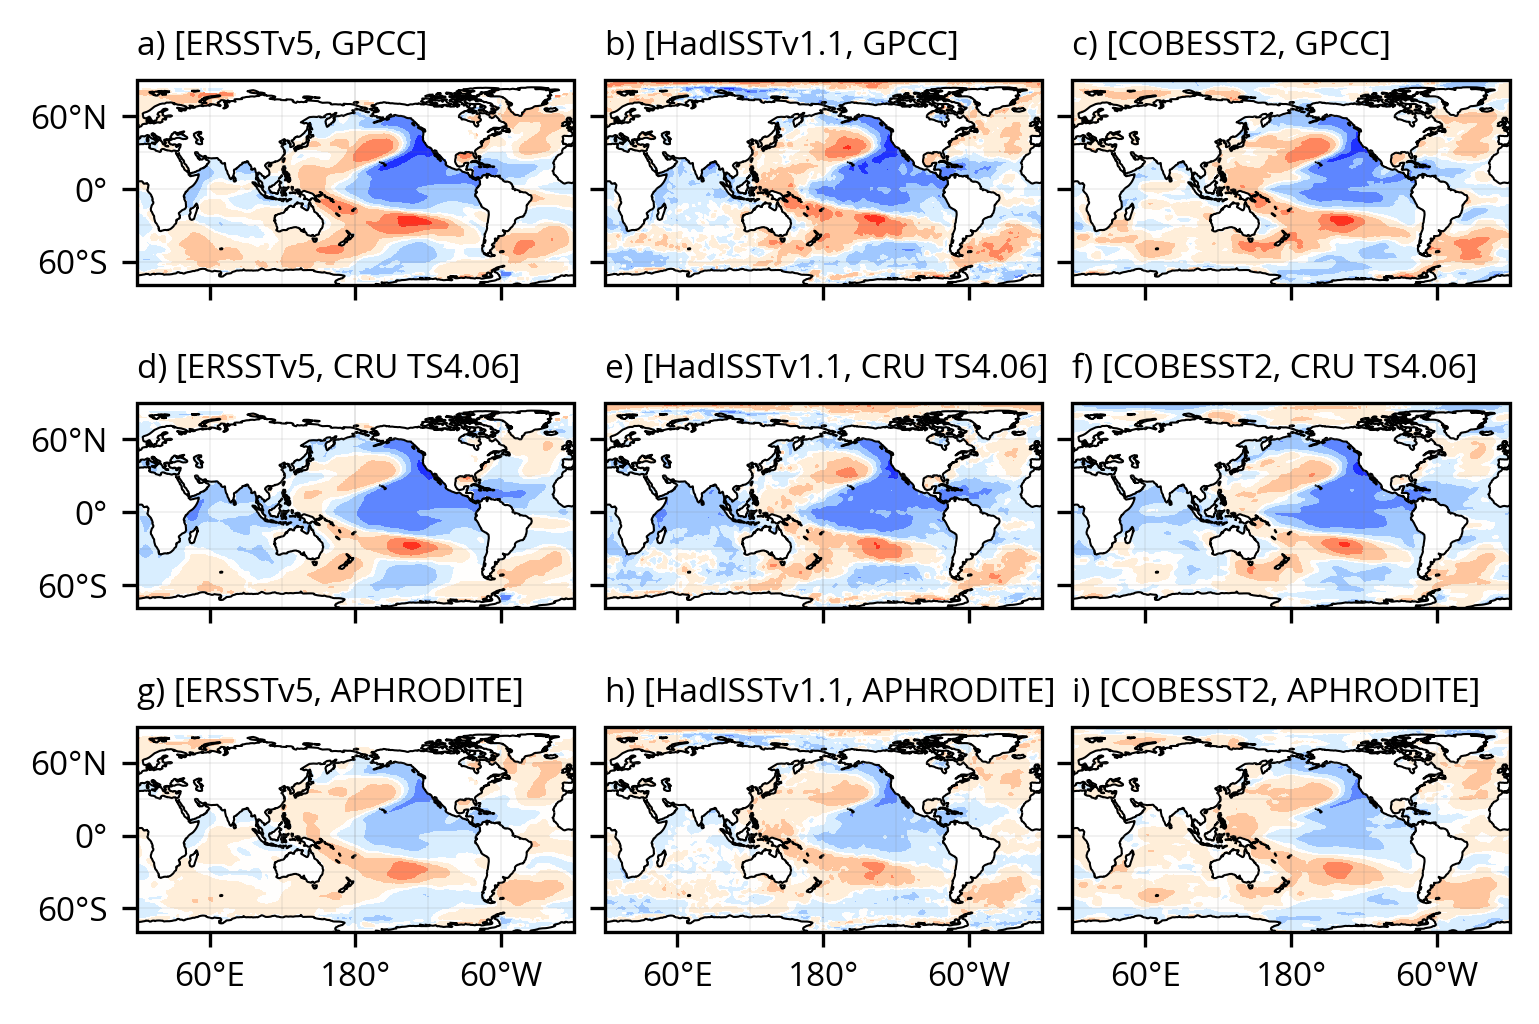

In [18]:
%matplotlib inline 

utils.set_matplotlib_font("Open Sans")

color = 'black'

mpl.rcParams.update({
    'axes.edgecolor': color,      # Color of the axes spines
    'xtick.color': color,         # Color of the x-axis ticks
    'ytick.color': color,         # Color of the y-axis ticks
    'xtick.labelcolor': color,    # Color of the x-axis tick labels
    'ytick.labelcolor': color,    # Color of the y-axis tick labels
    'grid.color': color,          # Color of the grid lines
    'axes.labelcolor': color,     # Color of the axis labels
    'axes.titlecolor': color,     # Color of the plot titles
})

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 15 
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

gs1 = GridSpec(3, 3, hspace = 0.32, wspace=0.07)
ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs1[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = fig.add_subplot(gs1[0, 2], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax5 = fig.add_subplot(gs1[1, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax6 = fig.add_subplot(gs1[1, 2], projection=ccrs.PlateCarree(central_longitude=180))
ax7 = fig.add_subplot(gs1[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax8 = fig.add_subplot(gs1[2, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax9 = fig.add_subplot(gs1[2, 2], projection=ccrs.PlateCarree(central_longitude=180))

axs = [
    ax1, ax2, ax3, 
    ax4, ax5, ax6,
    ax7, ax8, ax9]

# For regrid the SST data to be the same as CESM-LE
reg_mean_ds = reg_model_mean.to_dataset(name='cesm')
dst_grid = gcgridobj.latlontools.extract_grid(reg_mean_ds)
lat = reg_mean_ds['lat'].values
lon = reg_mean_ds['lon'].values

all_regs = []
for i, (precip_anm, sst_anm, title, ax) in enumerate(zip(precip_anms, sst_anms, titles, axs)):
    time = sst_anm.time.values
    sst_anm_ds = sst_anm.to_dataset(name='sst')
    src_grid = gcgridobj.latlontools.extract_grid(sst_anm_ds)
    regridder = gcgridobj.regrid.gen_regridder(src_grid, dst_grid)
    sst_anm_regridded = regridder(sst_anm)
    sst_anm0 = xr.DataArray(sst_anm_regridded, 
                            coords={'time': time, 'lat': lat, 'lon': lon},
                            dims=['time', 'lat', 'lon'])
    sst_anm00 = sst_anm0.resample(time='QS-DEC', label='left').mean()
    sst_anm000 = sst_anm00.sel(time=sst_anm00.time.dt.month.isin([12])).resample(time='1Y').mean()

    # Step three: regression of MSEA precipitation (y) onto global SSTs (x)
    # standardized SST anomalies
    sst_standardized = sst_anm000 / sst_anm000.std(dim='time')
    #regression = cov(x,y) / variance (x)
    # outcome (y) is regressed onto the predictors (x)
    cov = xr.cov(sst_standardized, precip_anm, dim="time")
    var = sst_standardized.var(dim="time", skipna=True)
    reg = cov / var
    all_regs.append(reg)

    im = draw_regression_map(reg, ax)
    ax.set_title(title, loc="left", fontsize=8)

    ax.set_yticks([-60, 0, 60], crs=ccrs.PlateCarree())
    ax.set_yticklabels([], fontsize=8)
    ax.set_xticks([60, 180, 300], crs=ccrs.PlateCarree())
    ax.set_xticklabels([], fontsize=8)


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

    

axs = [ax1, ax4, ax7]
for i, ax in enumerate(axs):

    ax.set_yticks([-60, 0, 60], crs=ccrs.PlateCarree())
    ax.set_yticklabels([-60, 0, 60], fontsize=8)

    ax.tick_params(axis='y', which='major', labelsize=8)  # Set tick params for each ax

    ax.yaxis.set_major_formatter(lat_formatter)

axs = [ax7, ax8, ax9]
for i, ax in enumerate(axs):

    ax.set_xticks([60, 180, 300], crs=ccrs.PlateCarree())
    ax.set_xticklabels([60, 180, 300], fontsize=8)

    ax.xaxis.set_major_formatter(lon_formatter)

#plt.savefig("FigS2.png")



In [28]:
# Concatenate Spatial Correlation Coefficients
all_regs_da = xr.concat(all_regs, dim='source')

# Expand dimensions of reg_model_mean to add the source dimension
reg_model_mean_expanded = reg_model_mean.expand_dims(source=1)

# Add CESM2 model mean regression coefficients
all_regs_da_concatenated = xr.concat([all_regs_da, reg_model_mean_expanded], dim='source')


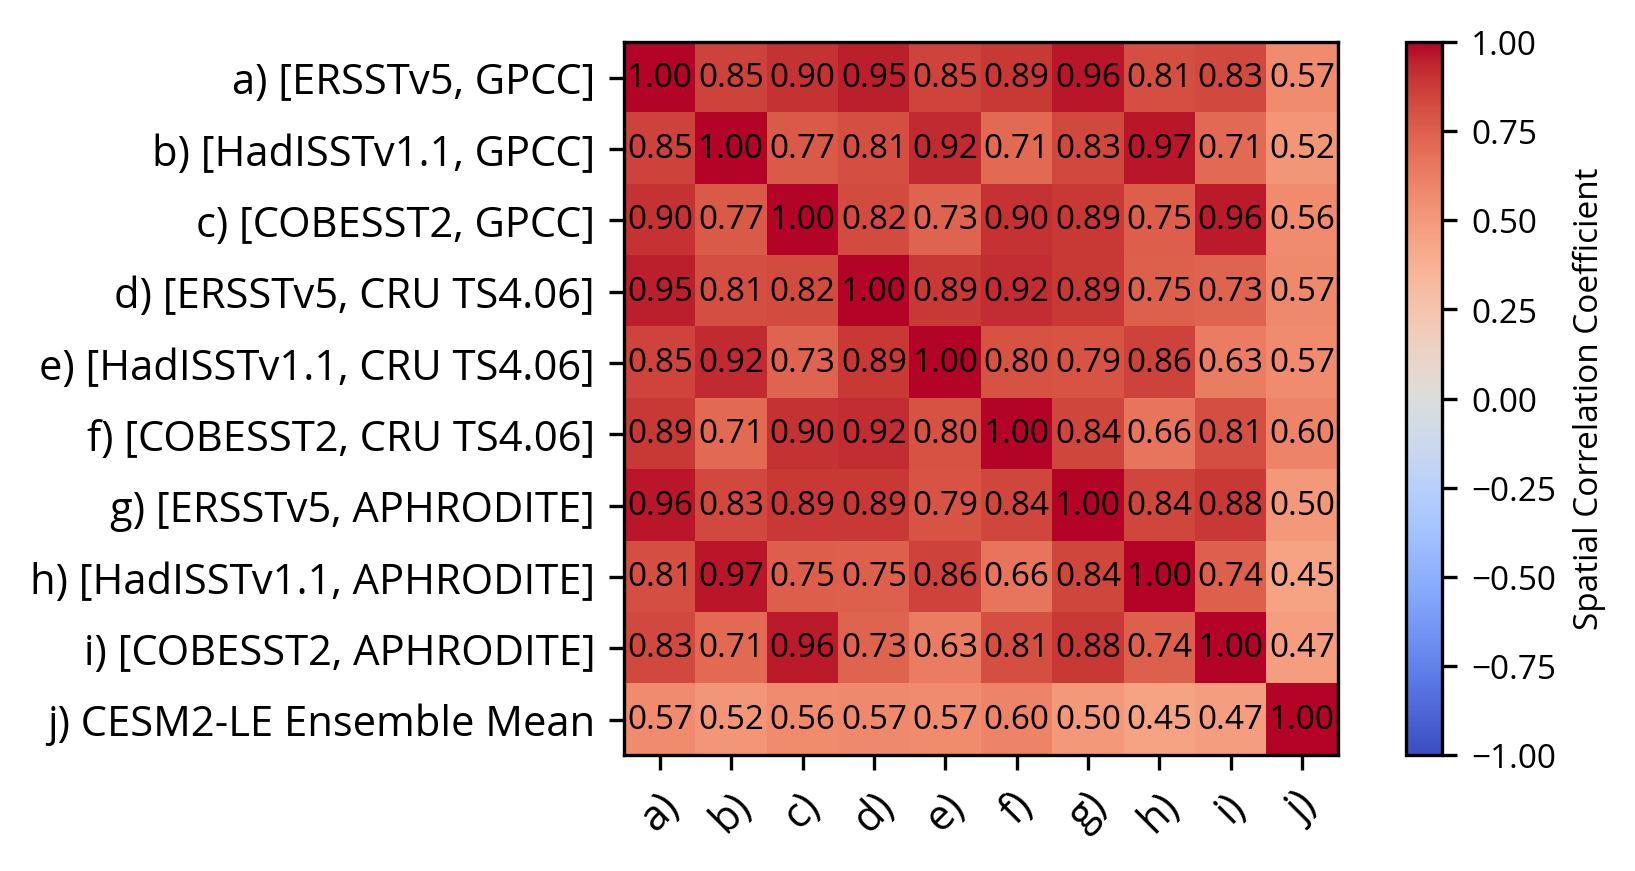

In [46]:
# Initialize a 9x9 matrix to store the correlation coefficients
correlation_matrix = np.zeros((10, 10))

# Calculate the correlation coefficients
for i in range(10):
    for j in range(10):
        if i == j:
            correlation_matrix[i, j] = 1  # Correlation with itself is 1
        else:
            correlation_matrix[i, j] = xr.corr(all_regs_da_concatenated.isel(source=i), all_regs_da_concatenated.isel(source=j)).item()

# Plot the correlation matrix
fig_width_cm = 15
fig_height_cm = 8
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Spatial Correlation Coefficient',)

labels_y= [
    "a) [ERSSTv5, GPCC]", "b) [HadISSTv1.1, GPCC]", "c) [COBESST2, GPCC]",
    "d) [ERSSTv5, CRU TS4.06]", "e) [HadISSTv1.1, CRU TS4.06]", "f) [COBESST2, CRU TS4.06]",
    "g) [ERSSTv5, APHRODITE]", "h) [HadISSTv1.1, APHRODITE]", "i) [COBESST2, APHRODITE]",
    "j) CESM2-LE Ensemble Mean"
    ]

labels_x = [
    "a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)",
]
plt.xticks(ticks=np.arange(10), labels=[labels_x[i] for i in range(10)], rotation=45, fontsize=10)
plt.yticks(ticks=np.arange(10), labels=[labels_y[i] for i in range(10)], fontsize=10)


# Annotate the correlation coefficients
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

plt.savefig("FigS3.png")